In [1]:
import sys
import torchOptics.optics as tt
import warnings
import torch.nn as nn
import torchOptics.metrics as tm
import torch.nn.functional as F
import torch.optim
import torch
from torch.utils.data import Dataset, DataLoader
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torchvision
import datetime
import tqdm
import time
import HHS.model


warnings.filterwarnings('ignore')


start_channel = 16
out_channel = 24
channels = [start_channel, start_channel*2, start_channel*4, start_channel*8]

In [29]:
import torchOptics.optics as tt
import warnings
import torch.nn as nn
import torchOptics.metrics as tm
import torch.nn.functional as F
import torch.optim
import torch
from torch.utils.data import Dataset, DataLoader
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torchvision
import datetime
import tqdm
import time
import HHS.model


warnings.filterwarnings('ignore')


class SignFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        t = torch.Tensor([0.5]).cuda()  # threshold
        output = (input > t).float() * 1
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output * torch.ones_like(input)  # Replace with your custom gradient computation
        return grad_input


class Dataset512(Dataset):
    def __init__(self, target_dir, meta, transform=None, isTrain=True):
        self.target_dir = target_dir
        self.transform = transform
        self.meta = meta
        self.isTrain = isTrain
        self.target_list = sorted(glob.glob(target_dir+'*.png'))
        self.center_crop = torchvision.transforms.CenterCrop(512)
        self.random_crop = torchvision.transforms.RandomCrop((512, 512))

    def __len__(self):
        return len(self.target_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        target = tt.imread(self.target_list[idx], meta=meta)
        if self.isTrain:
            target = self.random_crop(target)
        else:
            target = self.center_crop(target)
        return target


def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform_(m.weight.data, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight.data)
        nn.init.constant_(m.bias.data, 0)

# load data
batch_size = 1
target_dir = 'dataset/DIV2K/DIV2K_train_HR/'
valid_dir = 'dataset/DIV2K/DIV2K_valid_HR/'
# sim_dir = 'binary_dataset/simulated/'
meta = {'wl' : (638e-9, 515e-9, 450e-9), 'dx':(6.3e-6, 6.3e-6)}
train_dataset = Dataset512(target_dir=target_dir, meta=meta, isTrain=True)
valid_dataset = Dataset512(target_dir=valid_dir, meta=meta, isTrain=False)

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
validloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)


def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform_(m.weight.data, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight.data)
        nn.init.constant_(m.bias.data, 0)


def train(model, num_hologram=10, custom_name='fcn', epochs=100, lr=1e-4, z=2e-3):
    date = datetime.datetime.now() - datetime.timedelta(hours=15)
    mean_psnr_list = []
    mean_mse_list = []
    max_epoch = 0
    max_psnr = 0
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    sign_function = SignFunction.apply
    # path = 'models/'
    model_name = f'{date}_{custom_name}_{num_hologram}_{z}'
    # make result folder
    result_folder = 'result/'+model_name
    os.mkdir(result_folder)
    model_path = os.path.join(result_folder, model_name)
    psnr_result_path = os.path.join(result_folder, 'meanPSNR.npy')
    mse_result_path = os.path.join(result_folder, 'meanMSE.npy')
    result = {'model_path': model_path, 'psnr_result_path': psnr_result_path,
          'mse_result_path': mse_result_path, 'z': z,
          'num_hologram': num_hologram, 'lr': lr, 'epochs': epochs}
    # save result dict
    with open(os.path.join(result_folder, 'result_dict.pickle'), 'wb') as fw:
        pickle.dump(result, fw)
    for epoch in range(epochs):
        pbar = tqdm.tqdm(trainloader)
        model.train()
        for target in pbar:
            out = model(target)
            binary = sign_function(out)
            sim = tt.simulate(binary, z).abs()**2
            result = torch.mean(sim, dim=1, keepdim=True)
            loss = tt.relativeLoss(result, target, F.mse_loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        model.eval()
        with torch.no_grad():
            psnrList = []
            mseList = []
            for valid in validloader:
                out = model(valid)
                binary = sign_function(out)
                sim = tt.simulate(binary, z).abs()**2
                result = torch.mean(sim, dim=1, keepdim=True)
                psnr = tt.relativeLoss(result, valid, tm.get_PSNR)
                psnrList.append(psnr)
                mse = tt.relativeLoss(result, valid, F.mse_loss).detach().cpu().numpy()
                mseList.append(mse)
            mean_psnr = sum(psnrList)/len(psnrList)
            mean_mse = sum(mseList)/len(mseList)
            mean_psnr_list.append(mean_psnr)
            mean_mse_list.append(mean_mse)
            # save psnr and mse
            np.save(psnr_result_path, mean_psnr_list)
            np.save(mse_result_path, mean_mse_list)
            plt.plot(np.arange(len(mean_psnr_list)), mean_psnr_list,
                     label=f'max psnr: {max(mean_psnr_list)}')
            plt.title(model_name+'_psnr')
            plt.legend()
            plt.savefig(os.path.join(result_folder, 'meanPSNR.png'))
            plt.clf()
            plt.plot(np.arange(len(mean_mse_list)), mean_mse_list,
                     label=f'max psnr: {min(mean_mse_list)}')
            plt.title(model_name+'_mse')
            plt.legend()
            plt.savefig(os.path.join(result_folder, 'meanMSE.png'))
            plt.clf()
            print(f'mean PSNR : {mean_psnr} {epoch}/{epochs}')
            print(f'mean MSE : {mean_mse} {epoch}/{epochs}')

        if mean_psnr > max_psnr:
            max_psnr = mean_psnr
            max_epoch = epoch
            torch.save(model.state_dict(), model_path)
        print(f'max_psnr: {max_psnr}, epoch: {max_epoch}')


def binary_sim(out, z=2e-3):
    binary = SignFunction.apply(out)
    sim = tt.simulate(binary, z).abs()**2
    res = torch.mean(sim, dim=1, keepdim=True)
    return binary, res


def valid(model):
    with torch.no_grad():
        psnr_list = []
        for target in validloader:
            out = model(target)
            binary, res = binary_sim(out)
            psnr = tt.relativeLoss(res, target, tm.get_PSNR)
            psnr_list.append(psnr)
    print(sum(psnr_list)/len(psnr_list))


def check_order(bmodel, classifier, target):
    if len(target.shape) == 3:
        target = target.unsqueeze(0)
    result = []
    with torch.no_grad():
        out = bmodel(target)
        binary, res = binary_sim(out)
        for i in range(10):
            binary_input = binary[0][i].unsqueeze(0).unsqueeze(0)
            prop_order = classifier(binary_input)
            result.append(torch.argmax(prop_order))
    print(result)


def check_order_without_model(binary, classifier):
    with torch.no_grad():
        result = []
        for i in range(10):
            binary_input = binary[0][i].unsqueeze(0).unsqueeze(0)
            prop_order = classifier(binary_input)
            result.append(torch.argmax(prop_order))
    print(result)


class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc = nn.Linear(64 * 64 * 64, 10)  # 최종 분류를 위한 FC 레이어

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
        x = x.view(-1, 64 * 64 * 64)  # flatten
        x = self.fc(x)
        return x


def rgb_binary_sim(out, z):
    meta = {'wl' : (638e-9, 515e-9, 450e-9), 'dx':(6.3e-6, 6.3e-6)}
    rmeta = {'wl': (638e-9), 'dx': (6.3e-6, 6.3e-6)}
    gmeta = {'wl': (515e-9), 'dx': (6.3e-6, 6.3e-6)}
    bmeta = {'wl': (450e-9), 'dx': (6.3e-6, 6.3e-6)}
    sign = SignFunction.apply
    binary = sign(out)
    channel = out.shape[1]
    rchannel = int(channel/3)
    gchannel = int(channel*2/3)
    red = binary[:, :rchannel, :, :]
    green = binary[:, rchannel:gchannel, :, :]
    blue = binary[:, gchannel:, :, :]
    red = tt.Tensor(red, meta=rmeta)
    green = tt.Tensor(green, meta=gmeta)
    blue = tt.Tensor(blue, meta=bmeta)
    rsim = tt.simulate(red, z).abs()**2
    gsim = tt.simulate(green, z).abs()**2
    bsim = tt.simulate(blue, z).abs()**2
    rmean = torch.mean(rsim, dim=1, keepdim=True)
    gmean = torch.mean(gsim, dim=1, keepdim=True)
    bmean = torch.mean(bsim, dim=1, keepdim=True)
    rgb = torch.cat([rmean, gmean, bmean], dim=1)
    rgb = tt.Tensor(rgb, meta=meta)
    binary = tt.Tensor(binary, meta=meta)
    return binary, rgb

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [7]:
meta = {'wl' : (638e-9, 515e-9, 450e-9), 'dx':(6.3e-6, 6.3e-6)}

class Dataset512(Dataset):
    def __init__(self, target_dir, meta, transform=None, isTrain=True):
        self.target_dir = target_dir
        self.transform = transform
        self.meta = meta
        self.isTrain = isTrain
        self.target_list = sorted(glob.glob(target_dir+'*.png'))
        self.center_crop = torchvision.transforms.CenterCrop(512)
        self.random_crop = torchvision.transforms.RandomCrop((512, 512))

    def __len__(self):
        return len(self.target_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        target = tt.imread(self.target_list[idx], meta=meta)
        if self.isTrain:
            target = self.random_crop(target)
        else:
            target = self.center_crop(target)
        return target


batch_size = 1
# target_dir = '../../../../nfs/dataset/DF2K/'
target_dir = 'dataset/DIV2K/DIV2K_train_HR/'
valid_dir = 'dataset/DIV2K/DIV2K_valid_HR/'
train_dataset = Dataset512(target_dir=target_dir, meta=meta, isTrain=True)
valid_dataset = Dataset512(target_dir=valid_dir, meta=meta, isTrain=False)
train_dataset_center = Dataset512(target_dir=target_dir, meta=meta, isTrain=False)
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
validloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
train_center_loader = DataLoader(train_dataset_center, batch_size=batch_size, shuffle=False)

In [8]:
class SignFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        t = torch.Tensor([0.5]).cuda()  # threshold
        output = (input > t).float() * 1
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output * torch.ones_like(input)  # Replace with your custom gradient computation
        return grad_input

In [18]:
def valid(model):
    z = 2e-3
    crop = torchvision.transforms.CenterCrop(480)
    psnr_list = []
    for target in tqdm.tqdm(validloader):
        out = model(target)
        binary, rgb = rgb_binary_sim(out, z)
        rgb = crop(rgb)
        croped_target = crop(target)
        psnr = tt.relativeLoss(rgb, croped_target, tm.get_PSNR)
        psnr_list.append(psnr)
    return psnr_list


def valid_train(model):
    z = 2e-3
    crop = torchvision.transforms.CenterCrop(480)
    psnr_list = []
    for target in tqdm.tqdm(train_center_loader):
        out = model(target)
        binary, rgb = rgb_binary_sim(out, z)
        rgb = crop(rgb)
        croped_target = crop(target)
        psnr = tt.relativeLoss(rgb, croped_target, tm.get_PSNR)
        psnr_list.append(psnr)
    return psnr_list

In [26]:
def rgb_binary_sim(out, z):
    meta = {'wl' : (638e-9, 515e-9, 450e-9), 'dx':(6.3e-6, 6.3e-6)}
    rmeta = {'wl': (638e-9), 'dx': (6.3e-6, 6.3e-6)}
    gmeta = {'wl': (515e-9), 'dx': (6.3e-6, 6.3e-6)}
    bmeta = {'wl': (450e-9), 'dx': (6.3e-6, 6.3e-6)}
    sign = SignFunction.apply
    binary = sign(out)
    channel = out.shape[1]
    rchannel = int(channel/3)
    gchannel = int(channel*2/3)
    red = binary[:, :rchannel, :, :]
    green = binary[:, rchannel:gchannel, :, :]
    blue = binary[:, gchannel:, :, :]
    red = tt.Tensor(red, meta=rmeta)
    green = tt.Tensor(green, meta=gmeta)
    blue = tt.Tensor(blue, meta=bmeta)
    rsim = tt.simulate(red, z).abs()**2
    gsim = tt.simulate(green, z).abs()**2
    bsim = tt.simulate(blue, z).abs()**2
    rmean = torch.mean(rsim, dim=1, keepdim=True)
    gmean = torch.mean(gsim, dim=1, keepdim=True)
    bmean = torch.mean(bsim, dim=1, keepdim=True)
    rgb = torch.cat([rmean, gmean, bmean], dim=1)
    rgb = tt.Tensor(rgb, meta=meta)
    binary = tt.Tensor(binary, meta=meta)
    return binary, rgb

100%|██████████| 100/100 [00:08<00:00, 11.19it/s]


[]

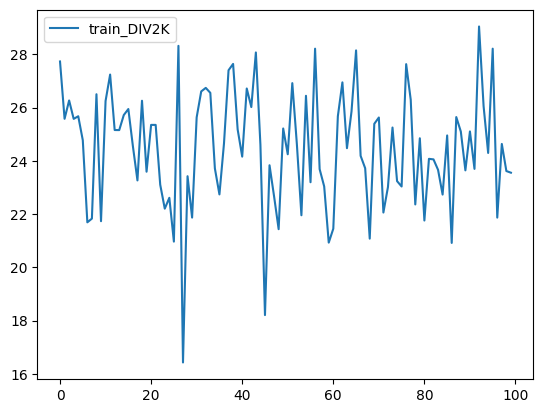

In [21]:
start_channel = 16
out_channel = 24
channels = [start_channel, start_channel*2, start_channel*4, start_channel*8]
model = HHS.model.FCN_Leakey_4(out_channel, 'Sigmoid', 3, channels = channels).cuda()
model.load_state_dict(torch.load('result/16/layer62024-05-13 12:36:25.883544_[16, 32, 64, 128]_24_24_0.002/2024-05-13 12:36:25.883544_[16, 32, 64, 128]_24_24_0.002'))
model.eval()
psnr_list = valid(model)
plt.plot(np.arange(len(psnr_list)), psnr_list, label='train_DIV2K')
plt.legend()
plt.plot()

In [22]:
np.mean(psnr_list)

24.48225461959839

100%|██████████| 800/800 [01:08<00:00, 11.62it/s]


[]

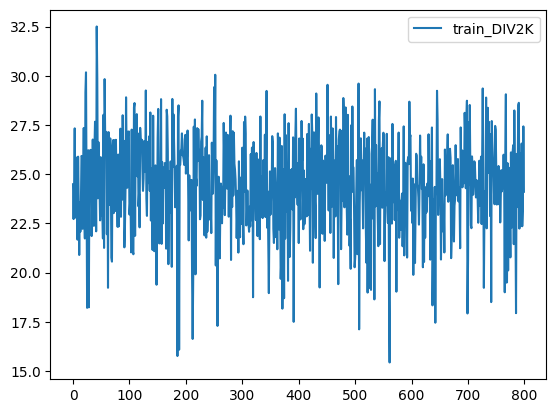

In [36]:
psnr_list = valid_train(model)
plt.plot(np.arange(len(psnr_list)), psnr_list, label='train_DIV2K')
plt.legend()
plt.plot()

In [39]:
difficult_list = []
for i in range(len(psnr_list)):
    if psnr_list[i] < 21:
        difficult_list.append(i)
print(len(difficult_list))
print(np.mean(psnr_list))

69
24.43309729337692


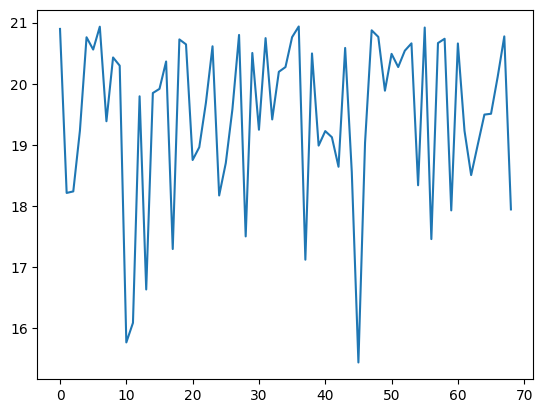

In [40]:
psnr_list = []
crop = torchvision.transforms.CenterCrop(480)
for idx in difficult_list:
    target = train_dataset_center[idx].unsqueeze(0)
    out = model(target)
    binary, rgb = rgb_binary_sim(out, 2e-3)
    crop_rgb = crop(rgb)
    crop_target = crop(target)
    psnr = tt.relativeLoss(crop_rgb, crop_target, tm.get_PSNR)
    psnr_list.append(psnr)
plt.plot(np.arange(len(psnr_list)), psnr_list)
plt.show()


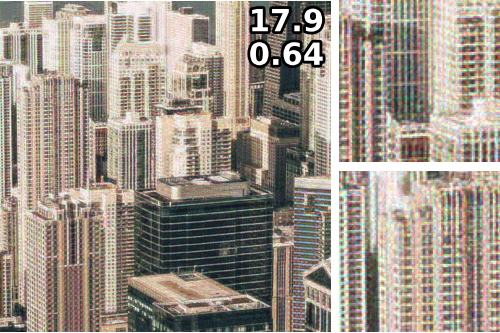

In [41]:
tt.show_with_insets(crop_rgb, crop_target, correct_colorwise=True)

In [42]:
np.mean(psnr_list)

19.46139377096425

In [13]:
def rgb_binary_train_padding(model, num_hologram=10, custom_name='fcn', epochs=100, lr=1e-4, z=2e-3, dataset='DIV2K'):
    date = datetime.datetime.now() - datetime.timedelta(hours=15)
    model.apply(initialize_weights)
    mean_psnr_list = []
    mean_mse_list = []
    max_epoch = 0
    max_psnr = 0
    crop = torchvision.transforms.CenterCrop(480)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    sign_function = SignFunction.apply
    # path = 'models/'
    model_name = f'{date}_{custom_name}_{num_hologram}_{z}'
    # make result folder
    result_folder = 'result/layer6'+model_name
    os.mkdir(result_folder)
    num_parameters = count_parameters(model)
    model_path = os.path.join(result_folder, 'best')
    final_psth = os.path.join(result_folder, 'final')
    psnr_result_path = os.path.join(result_folder, 'meanPSNR.npy')
    mse_result_path = os.path.join(result_folder, 'meanMSE.npy')
    result = {'model_path': model_path, 'psnr_result_path': psnr_result_path,
          'mse_result_path': mse_result_path, 'z': z,
          'num_hologram': num_hologram, 'lr': lr, 'epochs': epochs,
            'num_parameters': num_parameters, 'channels': channels,
             'dataset': dataset}
    # save result dict
    train_psnr_list = []
    train_loss_list = []
    with open(os.path.join(result_folder, 'result_dict.pickle'), 'wb') as fw:
        pickle.dump(result, fw)
    for epoch in range(epochs):
        model.train()
        sum_train_psnr = 0
        sum_train_loss = 0
        for idx in tqdm.tqdm(difficult_list):
            target = train_dataset_center[idx].unsqueeze(0)
            out = model(target)
            binary, rgb = rgb_binary_sim(out, z)
            rgb = crop(rgb)
            croped_target = crop(target)
            loss = tt.relativeLoss(rgb, croped_target, F.mse_loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            psnr = tt.relativeLoss(rgb, croped_target, tm.get_PSNR)
            sum_train_psnr = sum_train_psnr + psnr
            sum_train_loss = sum_train_loss + loss.detach().cpu().numpy()
        mean_train_psnr = sum_train_psnr/len(difficult_list)
        mean_train_loss = sum_train_loss/len(difficult_list)
        train_psnr_list.append(mean_train_psnr)
        train_loss_list.append(mean_train_loss)

        plt.plot(np.arange(len(train_psnr_list)), train_psnr_list, label=f'max psnr: {max(train_psnr_list)}')
        plt.title(model_name+'_train_psnr')
        plt.legend()
        plt.savefig(os.path.join(result_folder, 'trainPSNR.png'))
        plt.clf()
        
        plt.plot(np.arange(len(train_loss_list)), train_loss_list, label=f'min mse: {min(train_loss_list)}')
        plt.title(model_name+'_train_loss')
        plt.legend()
        plt.savefig(os.path.join(result_folder, 'trainMSE.png'))
        plt.clf()
        
        model.eval()
        with torch.no_grad():
            psnrList = []
            mseList = []
            for idx, valid in enumerate(validloader):
                out = model(valid)
                binary, rgb = rgb_binary_sim(out, z)
                rgb = crop(rgb)
                croped_target = crop(valid)
                psnr = tt.relativeLoss(rgb, croped_target, tm.get_PSNR)
                psnrList.append(psnr)
                mse = tt.relativeLoss(rgb, croped_target, F.mse_loss).detach().cpu().numpy()
                mseList.append(mse)
                if idx == 0:
                    pl = tt.show_with_insets(rgb, croped_target, correct_colorwise=True)
                    pl.save(os.path.join(result_folder, 'penguin.png'))
            mean_psnr = sum(psnrList)/len(psnrList)
            mean_mse = sum(mseList)/len(mseList)
            mean_psnr_list.append(mean_psnr)
            mean_mse_list.append(mean_mse)
            # save psnr and mse
            np.save(psnr_result_path, mean_psnr_list)
            np.save(mse_result_path, mean_mse_list)
            plt.plot(np.arange(len(mean_psnr_list)), mean_psnr_list,
                     label=f'max psnr: {max(mean_psnr_list)}')
            plt.title(model_name+'_psnr')
            plt.legend()
            plt.savefig(os.path.join(result_folder, 'meanPSNR.png'))
            plt.clf()
            plt.plot(np.arange(len(mean_mse_list)), mean_mse_list,
                     label=f'min mse: {min(mean_mse_list)}')
            plt.title(model_name+'_mse')
            plt.legend()
            plt.savefig(os.path.join(result_folder, 'meanMSE.png'))
            plt.clf()
            print(f'mean PSNR : {mean_psnr} {epoch}/{epochs}')
            print(f'mean MSE : {mean_mse} {epoch}/{epochs}')

        if mean_psnr > max_psnr:
            max_psnr = mean_psnr
            max_epoch = epoch
            torch.save(model.state_dict(), model_path)
        torch.save(model.state_dict(), final_psth)
        print(f'max_psnr: {max_psnr}, epoch: {max_epoch}')

In [ ]:
model.train()
# 기존에는 dataset A에 대해서 학습하던 코드인데 dataset B를 학습하게 수정했습니다.
rgb_binary_train_padding(model, num_hologram=24, custom_name='difficult_case', epochs=500, lr=1e-4, z=2e-3)

100%|██████████| 69/69 [00:09<00:00,  7.27it/s]


mean PSNR : 14.159264535903931 0/500
mean MSE : 0.04018542450852692 0/500
max_psnr: 14.159264535903931, epoch: 0


100%|██████████| 69/69 [00:08<00:00,  7.72it/s]


mean PSNR : 16.09994104385376 1/500
mean MSE : 0.025565187791362406 1/500
max_psnr: 16.09994104385376, epoch: 1


100%|██████████| 69/69 [00:09<00:00,  7.41it/s]


mean PSNR : 17.351797609329225 2/500
mean MSE : 0.019252454414963722 2/500
max_psnr: 17.351797609329225, epoch: 2


100%|██████████| 69/69 [00:10<00:00,  6.68it/s]


mean PSNR : 18.00418007850647 3/500
mean MSE : 0.016693504806607962 3/500
max_psnr: 18.00418007850647, epoch: 3


100%|██████████| 69/69 [00:14<00:00,  4.70it/s]


mean PSNR : 18.368696517944336 4/500
mean MSE : 0.01539160673506558 4/500
max_psnr: 18.368696517944336, epoch: 4


100%|██████████| 69/69 [00:13<00:00,  5.30it/s]


mean PSNR : 18.68522144317627 5/500
mean MSE : 0.014334529526531697 5/500
max_psnr: 18.68522144317627, epoch: 5


100%|██████████| 69/69 [00:12<00:00,  5.38it/s]


mean PSNR : 18.82585723876953 6/500
mean MSE : 0.013859267730731517 6/500
max_psnr: 18.82585723876953, epoch: 6


100%|██████████| 69/69 [00:13<00:00,  5.12it/s]


mean PSNR : 18.91102568626404 7/500
mean MSE : 0.01356291065691039 7/500
max_psnr: 18.91102568626404, epoch: 7


100%|██████████| 69/69 [00:08<00:00,  7.95it/s]


mean PSNR : 19.10337287902832 8/500
mean MSE : 0.012981608035042882 8/500
max_psnr: 19.10337287902832, epoch: 8


100%|██████████| 69/69 [00:08<00:00,  7.67it/s]


mean PSNR : 19.193930778503418 9/500
mean MSE : 0.012706520904321223 9/500
max_psnr: 19.193930778503418, epoch: 9


100%|██████████| 69/69 [00:08<00:00,  8.13it/s]


mean PSNR : 19.263521070480348 10/500
mean MSE : 0.012502685575745999 10/500
max_psnr: 19.263521070480348, epoch: 10


100%|██████████| 69/69 [00:09<00:00,  7.29it/s]


mean PSNR : 19.288364572525026 11/500
mean MSE : 0.01241314368788153 11/500
max_psnr: 19.288364572525026, epoch: 11


100%|██████████| 69/69 [00:08<00:00,  8.05it/s]


mean PSNR : 19.303343658447265 12/500
mean MSE : 0.012341045271605254 12/500
max_psnr: 19.303343658447265, epoch: 12


100%|██████████| 69/69 [00:08<00:00,  7.76it/s]


mean PSNR : 19.398999557495117 13/500
mean MSE : 0.012070522475987673 13/500
max_psnr: 19.398999557495117, epoch: 13


100%|██████████| 69/69 [00:09<00:00,  7.38it/s]


mean PSNR : 19.456237497329713 14/500
mean MSE : 0.011917687449604274 14/500
max_psnr: 19.456237497329713, epoch: 14


100%|██████████| 69/69 [00:09<00:00,  7.57it/s]


mean PSNR : 19.5900403213501 15/500
mean MSE : 0.011568254143930971 15/500
max_psnr: 19.5900403213501, epoch: 15


100%|██████████| 69/69 [00:09<00:00,  7.41it/s]


mean PSNR : 19.656139612197876 16/500
mean MSE : 0.011387666068039835 16/500
max_psnr: 19.656139612197876, epoch: 16


100%|██████████| 69/69 [00:09<00:00,  7.29it/s]


mean PSNR : 19.708061313629152 17/500
mean MSE : 0.011258116150274873 17/500
max_psnr: 19.708061313629152, epoch: 17


100%|██████████| 69/69 [00:08<00:00,  8.06it/s]


mean PSNR : 19.88427861213684 18/500
mean MSE : 0.010848579574376344 18/500
max_psnr: 19.88427861213684, epoch: 18


100%|██████████| 69/69 [00:09<00:00,  7.67it/s]


mean PSNR : 20.04175434112549 19/500
mean MSE : 0.010498136458918452 19/500
max_psnr: 20.04175434112549, epoch: 19


100%|██████████| 69/69 [00:09<00:00,  7.26it/s]


mean PSNR : 20.161586561203002 20/500
mean MSE : 0.010240993972402065 20/500
max_psnr: 20.161586561203002, epoch: 20


100%|██████████| 69/69 [00:08<00:00,  8.13it/s]


mean PSNR : 20.153227434158325 21/500
mean MSE : 0.010246217981912196 21/500
max_psnr: 20.161586561203002, epoch: 20


100%|██████████| 69/69 [00:08<00:00,  8.26it/s]


mean PSNR : 20.256507635116577 22/500
mean MSE : 0.010013282522559166 22/500
max_psnr: 20.256507635116577, epoch: 22


100%|██████████| 69/69 [00:09<00:00,  7.53it/s]


mean PSNR : 20.293056020736696 23/500
mean MSE : 0.009928541162516923 23/500
max_psnr: 20.293056020736696, epoch: 23


100%|██████████| 69/69 [00:09<00:00,  7.37it/s]


mean PSNR : 20.48294107437134 24/500
mean MSE : 0.009542371507268398 24/500
max_psnr: 20.48294107437134, epoch: 24


100%|██████████| 69/69 [00:08<00:00,  7.68it/s]


mean PSNR : 20.594561100006104 25/500
mean MSE : 0.009315705257467926 25/500
max_psnr: 20.594561100006104, epoch: 25


100%|██████████| 69/69 [00:08<00:00,  8.18it/s]


mean PSNR : 20.64367042541504 26/500
mean MSE : 0.009228183473460376 26/500
max_psnr: 20.64367042541504, epoch: 26


100%|██████████| 69/69 [00:08<00:00,  8.12it/s]


mean PSNR : 20.844837169647217 27/500
mean MSE : 0.008825876892078668 27/500
max_psnr: 20.844837169647217, epoch: 27


100%|██████████| 69/69 [00:11<00:00,  5.97it/s]


mean PSNR : 20.825617790222168 28/500
mean MSE : 0.008860431544017047 28/500
max_psnr: 20.844837169647217, epoch: 27


100%|██████████| 69/69 [00:08<00:00,  7.76it/s]


mean PSNR : 20.918439302444458 29/500
mean MSE : 0.008688494155649096 29/500
max_psnr: 20.918439302444458, epoch: 29


100%|██████████| 69/69 [00:08<00:00,  8.48it/s]


mean PSNR : 20.954346084594725 30/500
mean MSE : 0.008613409115932882 30/500
max_psnr: 20.954346084594725, epoch: 30


100%|██████████| 69/69 [00:08<00:00,  8.34it/s]


mean PSNR : 21.01575849533081 31/500
mean MSE : 0.008487318020779639 31/500
max_psnr: 21.01575849533081, epoch: 31


100%|██████████| 69/69 [00:08<00:00,  8.30it/s]


mean PSNR : 21.076891479492186 32/500
mean MSE : 0.008375129897613078 32/500
max_psnr: 21.076891479492186, epoch: 32


100%|██████████| 69/69 [00:08<00:00,  7.98it/s]


mean PSNR : 21.110418453216553 33/500
mean MSE : 0.008306800241116434 33/500
max_psnr: 21.110418453216553, epoch: 33


100%|██████████| 69/69 [00:08<00:00,  8.30it/s]


mean PSNR : 21.236109085083008 34/500
mean MSE : 0.008097247739788144 34/500
max_psnr: 21.236109085083008, epoch: 34


100%|██████████| 69/69 [00:08<00:00,  8.32it/s]


mean PSNR : 21.26001398086548 35/500
mean MSE : 0.008054402556736022 35/500
max_psnr: 21.26001398086548, epoch: 35


100%|██████████| 69/69 [00:08<00:00,  8.13it/s]


mean PSNR : 21.25620357513428 36/500
mean MSE : 0.008061459029559046 36/500
max_psnr: 21.26001398086548, epoch: 35


100%|██████████| 69/69 [00:08<00:00,  8.62it/s]


mean PSNR : 21.315002088546752 37/500
mean MSE : 0.00798784694634378 37/500
max_psnr: 21.315002088546752, epoch: 37


100%|██████████| 69/69 [00:07<00:00,  8.66it/s]


mean PSNR : 21.414846200942993 38/500
mean MSE : 0.007796834248583764 38/500
max_psnr: 21.414846200942993, epoch: 38


100%|██████████| 69/69 [00:07<00:00,  8.64it/s]


mean PSNR : 21.476832971572875 39/500
mean MSE : 0.0077076365798711775 39/500
max_psnr: 21.476832971572875, epoch: 39


100%|██████████| 69/69 [00:07<00:00,  8.68it/s]


mean PSNR : 21.58191732406616 40/500
mean MSE : 0.007538107184227556 40/500
max_psnr: 21.58191732406616, epoch: 40


100%|██████████| 69/69 [00:07<00:00,  8.66it/s]


mean PSNR : 21.60596616744995 41/500
mean MSE : 0.007496561284642667 41/500
max_psnr: 21.60596616744995, epoch: 41


100%|██████████| 69/69 [00:08<00:00,  8.52it/s]


mean PSNR : 21.644614114761353 42/500
mean MSE : 0.0074516181135550145 42/500
max_psnr: 21.644614114761353, epoch: 42


100%|██████████| 69/69 [00:08<00:00,  8.57it/s]


mean PSNR : 21.823783178329467 43/500
mean MSE : 0.007187505329493433 43/500
max_psnr: 21.823783178329467, epoch: 43


100%|██████████| 69/69 [00:08<00:00,  8.60it/s]


mean PSNR : 21.825144081115724 44/500
mean MSE : 0.007187263371888548 44/500
max_psnr: 21.825144081115724, epoch: 44


100%|██████████| 69/69 [00:07<00:00,  8.65it/s]


mean PSNR : 21.896308689117433 45/500
mean MSE : 0.0070991518092341725 45/500
max_psnr: 21.896308689117433, epoch: 45


100%|██████████| 69/69 [00:07<00:00,  8.64it/s]


mean PSNR : 21.79983798980713 46/500
mean MSE : 0.0071956217335537075 46/500
max_psnr: 21.896308689117433, epoch: 45


100%|██████████| 69/69 [00:07<00:00,  8.66it/s]


mean PSNR : 21.816753787994386 47/500
mean MSE : 0.0071724448422901335 47/500
max_psnr: 21.896308689117433, epoch: 45


100%|██████████| 69/69 [00:07<00:00,  9.06it/s]


mean PSNR : 21.894274311065672 48/500
mean MSE : 0.007066340260207653 48/500
max_psnr: 21.896308689117433, epoch: 45


100%|██████████| 69/69 [00:07<00:00,  9.03it/s]


mean PSNR : 21.735676794052125 49/500
mean MSE : 0.0072663563163951035 49/500
max_psnr: 21.896308689117433, epoch: 45


100%|██████████| 69/69 [00:07<00:00,  9.12it/s]


mean PSNR : 21.871693773269655 50/500
mean MSE : 0.007085038898512721 50/500
max_psnr: 21.896308689117433, epoch: 45


100%|██████████| 69/69 [00:07<00:00,  9.11it/s]


mean PSNR : 21.894056148529053 51/500
mean MSE : 0.0070517017599195245 51/500
max_psnr: 21.896308689117433, epoch: 45


100%|██████████| 69/69 [00:07<00:00,  8.91it/s]


mean PSNR : 21.702902069091795 52/500
mean MSE : 0.007311584455892444 52/500
max_psnr: 21.896308689117433, epoch: 45


100%|██████████| 69/69 [00:07<00:00,  8.99it/s]


mean PSNR : 21.95570340156555 53/500
mean MSE : 0.006990525722503662 53/500
max_psnr: 21.95570340156555, epoch: 53


100%|██████████| 69/69 [00:08<00:00,  7.80it/s]


mean PSNR : 21.732147941589357 54/500
mean MSE : 0.007254328595008701 54/500
max_psnr: 21.95570340156555, epoch: 53


100%|██████████| 69/69 [00:07<00:00,  8.73it/s]


mean PSNR : 21.7810400390625 55/500
mean MSE : 0.0072038607322610915 55/500
max_psnr: 21.95570340156555, epoch: 53


100%|██████████| 69/69 [00:08<00:00,  8.24it/s]


mean PSNR : 21.859453315734864 56/500
mean MSE : 0.007073414702899754 56/500
max_psnr: 21.95570340156555, epoch: 53


100%|██████████| 69/69 [00:08<00:00,  8.14it/s]


mean PSNR : 21.81732675552368 57/500
mean MSE : 0.0071298394724726676 57/500
max_psnr: 21.95570340156555, epoch: 53


100%|██████████| 69/69 [00:08<00:00,  8.35it/s]


mean PSNR : 21.813984632492065 58/500
mean MSE : 0.007136301959399134 58/500
max_psnr: 21.95570340156555, epoch: 53


100%|██████████| 69/69 [00:08<00:00,  8.29it/s]


mean PSNR : 21.795518341064454 59/500
mean MSE : 0.007156609063968062 59/500
max_psnr: 21.95570340156555, epoch: 53


100%|██████████| 69/69 [00:08<00:00,  8.09it/s]


mean PSNR : 21.457309494018556 60/500
mean MSE : 0.00769148109247908 60/500
max_psnr: 21.95570340156555, epoch: 53


100%|██████████| 69/69 [00:08<00:00,  7.93it/s]


mean PSNR : 21.343931970596312 61/500
mean MSE : 0.007906007531564683 61/500
max_psnr: 21.95570340156555, epoch: 53


100%|██████████| 69/69 [00:07<00:00,  8.99it/s]


mean PSNR : 21.6767537689209 62/500
mean MSE : 0.007344410480000079 62/500
max_psnr: 21.95570340156555, epoch: 53


100%|██████████| 69/69 [00:07<00:00,  8.80it/s]


mean PSNR : 21.731901149749756 63/500
mean MSE : 0.007233535663690418 63/500
max_psnr: 21.95570340156555, epoch: 53


100%|██████████| 69/69 [00:08<00:00,  8.15it/s]


mean PSNR : 21.780054206848146 64/500
mean MSE : 0.007195528300944716 64/500
max_psnr: 21.95570340156555, epoch: 53


100%|██████████| 69/69 [00:07<00:00,  8.99it/s]


mean PSNR : 21.909809131622314 65/500
mean MSE : 0.006983603781554848 65/500
max_psnr: 21.95570340156555, epoch: 53


100%|██████████| 69/69 [00:07<00:00,  9.05it/s]


mean PSNR : 22.09767903327942 66/500
mean MSE : 0.006732266570907086 66/500
max_psnr: 22.09767903327942, epoch: 66


100%|██████████| 69/69 [00:07<00:00,  9.04it/s]


mean PSNR : 22.173027954101563 67/500
mean MSE : 0.00665000977460295 67/500
max_psnr: 22.173027954101563, epoch: 67


100%|██████████| 69/69 [00:07<00:00,  8.99it/s]


mean PSNR : 22.115860452651976 68/500
mean MSE : 0.006721104518510402 68/500
max_psnr: 22.173027954101563, epoch: 67


100%|██████████| 69/69 [00:07<00:00,  9.02it/s]


mean PSNR : 21.974114809036255 69/500
mean MSE : 0.0069026976241730155 69/500
max_psnr: 22.173027954101563, epoch: 67


100%|██████████| 69/69 [00:08<00:00,  8.50it/s]


mean PSNR : 21.971095085144043 70/500
mean MSE : 0.006913806013762951 70/500
max_psnr: 22.173027954101563, epoch: 67


100%|██████████| 69/69 [00:08<00:00,  8.58it/s]


mean PSNR : 21.752090330123902 71/500
mean MSE : 0.00721968061523512 71/500
max_psnr: 22.173027954101563, epoch: 67


100%|██████████| 69/69 [00:08<00:00,  7.81it/s]


mean PSNR : 21.95247859954834 72/500
mean MSE : 0.006938406566623598 72/500
max_psnr: 22.173027954101563, epoch: 67


100%|██████████| 69/69 [00:08<00:00,  8.47it/s]


mean PSNR : 22.01447187423706 73/500
mean MSE : 0.006844989459495992 73/500
max_psnr: 22.173027954101563, epoch: 67


100%|██████████| 69/69 [00:08<00:00,  8.45it/s]


mean PSNR : 22.202905712127684 74/500
mean MSE : 0.006591522777453065 74/500
max_psnr: 22.202905712127684, epoch: 74


100%|██████████| 69/69 [00:07<00:00,  8.94it/s]


mean PSNR : 22.23547124862671 75/500
mean MSE : 0.006583021292462945 75/500
max_psnr: 22.23547124862671, epoch: 75


100%|██████████| 69/69 [00:08<00:00,  8.32it/s]


mean PSNR : 22.119855546951293 76/500
mean MSE : 0.006721087440382689 76/500
max_psnr: 22.23547124862671, epoch: 75


100%|██████████| 69/69 [00:07<00:00,  8.97it/s]


mean PSNR : 22.14027943611145 77/500
mean MSE : 0.006689572739414871 77/500
max_psnr: 22.23547124862671, epoch: 75


100%|██████████| 69/69 [00:07<00:00,  8.85it/s]


mean PSNR : 22.048970317840578 78/500
mean MSE : 0.006801411684136838 78/500
max_psnr: 22.23547124862671, epoch: 75


100%|██████████| 69/69 [00:07<00:00,  8.77it/s]


mean PSNR : 22.161446590423584 79/500
mean MSE : 0.006655881875194609 79/500
max_psnr: 22.23547124862671, epoch: 75


100%|██████████| 69/69 [00:07<00:00,  8.96it/s]


mean PSNR : 22.248918170928956 80/500
mean MSE : 0.006555159678682685 80/500
max_psnr: 22.248918170928956, epoch: 80


100%|██████████| 69/69 [00:07<00:00,  9.03it/s]


mean PSNR : 22.172068605422975 81/500
mean MSE : 0.006636467145290226 81/500
max_psnr: 22.248918170928956, epoch: 80


100%|██████████| 69/69 [00:08<00:00,  8.40it/s]


mean PSNR : 22.381068477630617 82/500
mean MSE : 0.006381643582135439 82/500
max_psnr: 22.381068477630617, epoch: 82


100%|██████████| 69/69 [00:07<00:00,  9.07it/s]


mean PSNR : 21.98968951225281 83/500
mean MSE : 0.0068648008140735324 83/500
max_psnr: 22.381068477630617, epoch: 82


100%|██████████| 69/69 [00:07<00:00,  9.12it/s]


mean PSNR : 22.041266441345215 84/500
mean MSE : 0.006807905179448426 84/500
max_psnr: 22.381068477630617, epoch: 82


100%|██████████| 69/69 [00:07<00:00,  9.21it/s]


mean PSNR : 22.505865068435668 85/500
mean MSE : 0.00623446507495828 85/500
max_psnr: 22.505865068435668, epoch: 85


100%|██████████| 69/69 [00:08<00:00,  8.49it/s]


mean PSNR : 22.47042830467224 86/500
mean MSE : 0.006281561767682433 86/500
max_psnr: 22.505865068435668, epoch: 85


100%|██████████| 69/69 [00:07<00:00,  9.12it/s]


mean PSNR : 22.33037311553955 87/500
mean MSE : 0.006438159490935505 87/500
max_psnr: 22.505865068435668, epoch: 85


100%|██████████| 69/69 [00:07<00:00,  9.01it/s]


mean PSNR : 22.1825244140625 88/500
mean MSE : 0.006649416519794613 88/500
max_psnr: 22.505865068435668, epoch: 85


100%|██████████| 69/69 [00:07<00:00,  8.79it/s]


mean PSNR : 22.043267517089845 89/500
mean MSE : 0.00681562362704426 89/500
max_psnr: 22.505865068435668, epoch: 85


100%|██████████| 69/69 [00:07<00:00,  8.68it/s]


mean PSNR : 22.103455572128297 90/500
mean MSE : 0.0067331598396413025 90/500
max_psnr: 22.505865068435668, epoch: 85


100%|██████████| 69/69 [00:08<00:00,  8.00it/s]


mean PSNR : 22.33197232246399 91/500
mean MSE : 0.006414031554013491 91/500
max_psnr: 22.505865068435668, epoch: 85


100%|██████████| 69/69 [00:08<00:00,  8.27it/s]


mean PSNR : 22.416185035705567 92/500
mean MSE : 0.006317523652687669 92/500
max_psnr: 22.505865068435668, epoch: 85


100%|██████████| 69/69 [00:08<00:00,  8.21it/s]


mean PSNR : 22.56152419090271 93/500
mean MSE : 0.006168108880519867 93/500
max_psnr: 22.56152419090271, epoch: 93


100%|██████████| 69/69 [00:08<00:00,  8.52it/s]


mean PSNR : 22.287329921722414 94/500
mean MSE : 0.006500983033329248 94/500
max_psnr: 22.56152419090271, epoch: 93


100%|██████████| 69/69 [00:08<00:00,  8.27it/s]


mean PSNR : 22.06809652328491 95/500
mean MSE : 0.00682406848995015 95/500
max_psnr: 22.56152419090271, epoch: 93


100%|██████████| 69/69 [00:07<00:00,  8.98it/s]


mean PSNR : 22.30866117477417 96/500
mean MSE : 0.006458495499100536 96/500
max_psnr: 22.56152419090271, epoch: 93


100%|██████████| 69/69 [00:09<00:00,  7.40it/s]


mean PSNR : 22.4282896900177 97/500
mean MSE : 0.006310554905794561 97/500
max_psnr: 22.56152419090271, epoch: 93


100%|██████████| 69/69 [00:07<00:00,  8.95it/s]


mean PSNR : 22.453001670837402 98/500
mean MSE : 0.006283629944082349 98/500
max_psnr: 22.56152419090271, epoch: 93


100%|██████████| 69/69 [00:07<00:00,  8.89it/s]


mean PSNR : 22.598919916152955 99/500
mean MSE : 0.006124361973488704 99/500
max_psnr: 22.598919916152955, epoch: 99


100%|██████████| 69/69 [00:07<00:00,  9.08it/s]


mean PSNR : 22.468702392578123 100/500
mean MSE : 0.00625909494701773 100/500
max_psnr: 22.598919916152955, epoch: 99


100%|██████████| 69/69 [00:08<00:00,  8.44it/s]


mean PSNR : 22.499718017578125 101/500
mean MSE : 0.006234838021919131 101/500
max_psnr: 22.598919916152955, epoch: 99


100%|██████████| 69/69 [00:08<00:00,  8.61it/s]


mean PSNR : 22.187187280654907 102/500
mean MSE : 0.006616118398960679 102/500
max_psnr: 22.598919916152955, epoch: 99


100%|██████████| 69/69 [00:07<00:00,  9.02it/s]


mean PSNR : 22.704275436401367 103/500
mean MSE : 0.00598325130995363 103/500
max_psnr: 22.704275436401367, epoch: 103


100%|██████████| 69/69 [00:08<00:00,  8.45it/s]


mean PSNR : 22.547603101730346 104/500
mean MSE : 0.006171840069582686 104/500
max_psnr: 22.704275436401367, epoch: 103


100%|██████████| 69/69 [00:08<00:00,  8.21it/s]


mean PSNR : 22.674576873779298 105/500
mean MSE : 0.006013514471706003 105/500
max_psnr: 22.704275436401367, epoch: 103


100%|██████████| 69/69 [00:08<00:00,  8.30it/s]


mean PSNR : 22.62904718399048 106/500
mean MSE : 0.006059018298983574 106/500
max_psnr: 22.704275436401367, epoch: 103


100%|██████████| 69/69 [00:08<00:00,  8.35it/s]


mean PSNR : 22.485805912017824 107/500
mean MSE : 0.006227981860283762 107/500
max_psnr: 22.704275436401367, epoch: 103


100%|██████████| 69/69 [00:08<00:00,  8.36it/s]


mean PSNR : 22.528472175598143 108/500
mean MSE : 0.006181578851537779 108/500
max_psnr: 22.704275436401367, epoch: 103


100%|██████████| 69/69 [00:08<00:00,  8.31it/s]


mean PSNR : 22.5477038192749 109/500
mean MSE : 0.006148712731665 109/500
max_psnr: 22.704275436401367, epoch: 103


100%|██████████| 69/69 [00:07<00:00,  8.81it/s]


mean PSNR : 22.54022376060486 110/500
mean MSE : 0.006149873397080227 110/500
max_psnr: 22.704275436401367, epoch: 103


100%|██████████| 69/69 [00:07<00:00,  9.00it/s]


mean PSNR : 22.409332246780394 111/500
mean MSE : 0.0063173270772676916 111/500
max_psnr: 22.704275436401367, epoch: 103


100%|██████████| 69/69 [00:07<00:00,  9.02it/s]


mean PSNR : 22.84693295478821 112/500
mean MSE : 0.005814466649899259 112/500
max_psnr: 22.84693295478821, epoch: 112


100%|██████████| 69/69 [00:08<00:00,  8.31it/s]


mean PSNR : 22.769868364334105 113/500
mean MSE : 0.005892770948121324 113/500
max_psnr: 22.84693295478821, epoch: 112


100%|██████████| 69/69 [00:07<00:00,  9.03it/s]


mean PSNR : 22.423709869384766 114/500
mean MSE : 0.0062782516237348315 114/500
max_psnr: 22.84693295478821, epoch: 112


100%|██████████| 69/69 [00:07<00:00,  9.02it/s]


mean PSNR : 22.39090792655945 115/500
mean MSE : 0.006321589491562918 115/500
max_psnr: 22.84693295478821, epoch: 112


100%|██████████| 69/69 [00:07<00:00,  8.98it/s]


mean PSNR : 22.310482349395752 116/500
mean MSE : 0.006446901886956766 116/500
max_psnr: 22.84693295478821, epoch: 112


100%|██████████| 69/69 [00:08<00:00,  8.38it/s]


mean PSNR : 22.479086494445802 117/500
mean MSE : 0.006199531756574288 117/500
max_psnr: 22.84693295478821, epoch: 112


100%|██████████| 69/69 [00:08<00:00,  8.58it/s]


mean PSNR : 22.500777740478515 118/500
mean MSE : 0.006184918755898252 118/500
max_psnr: 22.84693295478821, epoch: 112


100%|██████████| 69/69 [00:08<00:00,  8.33it/s]


mean PSNR : 22.059808502197267 119/500
mean MSE : 0.00676089622778818 119/500
max_psnr: 22.84693295478821, epoch: 112


100%|██████████| 69/69 [00:07<00:00,  8.93it/s]


mean PSNR : 22.644374389648437 120/500
mean MSE : 0.006012375114951282 120/500
max_psnr: 22.84693295478821, epoch: 112


100%|██████████| 69/69 [00:08<00:00,  8.46it/s]


mean PSNR : 22.628678007125856 121/500
mean MSE : 0.006040479629300535 121/500
max_psnr: 22.84693295478821, epoch: 112


100%|██████████| 69/69 [00:07<00:00,  8.74it/s]


mean PSNR : 22.645237379074096 122/500
mean MSE : 0.006017299453960731 122/500
max_psnr: 22.84693295478821, epoch: 112


100%|██████████| 69/69 [00:08<00:00,  8.19it/s]


mean PSNR : 22.15840796470642 123/500
mean MSE : 0.00662303319433704 123/500
max_psnr: 22.84693295478821, epoch: 112


100%|██████████| 69/69 [00:08<00:00,  8.15it/s]


mean PSNR : 22.036622009277345 124/500
mean MSE : 0.006798290562583134 124/500
max_psnr: 22.84693295478821, epoch: 112


100%|██████████| 69/69 [00:07<00:00,  8.63it/s]


mean PSNR : 22.17976360321045 125/500
mean MSE : 0.006590668256394565 125/500
max_psnr: 22.84693295478821, epoch: 112


100%|██████████| 69/69 [00:08<00:00,  8.26it/s]


mean PSNR : 22.143339700698853 126/500
mean MSE : 0.006620433328207582 126/500
max_psnr: 22.84693295478821, epoch: 112


100%|██████████| 69/69 [00:08<00:00,  8.60it/s]


mean PSNR : 22.629270811080932 127/500
mean MSE : 0.006000371113186702 127/500
max_psnr: 22.84693295478821, epoch: 112


100%|██████████| 69/69 [00:08<00:00,  8.54it/s]


mean PSNR : 22.754050464630126 128/500
mean MSE : 0.0058688741957303135 128/500
max_psnr: 22.84693295478821, epoch: 112


100%|██████████| 69/69 [00:07<00:00,  8.65it/s]


mean PSNR : 22.657664232254028 129/500
mean MSE : 0.00599456715863198 129/500
max_psnr: 22.84693295478821, epoch: 112


100%|██████████| 69/69 [00:07<00:00,  8.67it/s]


mean PSNR : 22.726748561859132 130/500
mean MSE : 0.005911766886711121 130/500
max_psnr: 22.84693295478821, epoch: 112


100%|██████████| 69/69 [00:07<00:00,  8.65it/s]


mean PSNR : 22.623446283340453 131/500
mean MSE : 0.00602955287322402 131/500
max_psnr: 22.84693295478821, epoch: 112


100%|██████████| 69/69 [00:08<00:00,  8.35it/s]


mean PSNR : 22.67088914871216 132/500
mean MSE : 0.005968609682749957 132/500
max_psnr: 22.84693295478821, epoch: 112


100%|██████████| 69/69 [00:08<00:00,  8.57it/s]


mean PSNR : 22.716973781585693 133/500
mean MSE : 0.005952653015265241 133/500
max_psnr: 22.84693295478821, epoch: 112


100%|██████████| 69/69 [00:08<00:00,  8.54it/s]


mean PSNR : 22.717860870361328 134/500
mean MSE : 0.005927985152229667 134/500
max_psnr: 22.84693295478821, epoch: 112


100%|██████████| 69/69 [00:08<00:00,  8.33it/s]


mean PSNR : 22.940050296783447 135/500
mean MSE : 0.005703870132565498 135/500
max_psnr: 22.940050296783447, epoch: 135


100%|██████████| 69/69 [00:08<00:00,  7.68it/s]


mean PSNR : 22.895017395019533 136/500
mean MSE : 0.0057304690068122 136/500
max_psnr: 22.940050296783447, epoch: 135


100%|██████████| 69/69 [00:08<00:00,  8.03it/s]


mean PSNR : 22.976057395935058 137/500
mean MSE : 0.0056748015130870045 137/500
max_psnr: 22.976057395935058, epoch: 137


100%|██████████| 69/69 [00:08<00:00,  8.02it/s]


mean PSNR : 22.911474599838257 138/500
mean MSE : 0.005744947483763098 138/500
max_psnr: 22.976057395935058, epoch: 137


100%|██████████| 69/69 [00:08<00:00,  8.60it/s]


mean PSNR : 22.834119358062743 139/500
mean MSE : 0.005820622117025778 139/500
max_psnr: 22.976057395935058, epoch: 137


100%|██████████| 69/69 [00:08<00:00,  8.42it/s]


mean PSNR : 22.856318063735962 140/500
mean MSE : 0.005775501290336251 140/500
max_psnr: 22.976057395935058, epoch: 137


100%|██████████| 69/69 [00:08<00:00,  8.62it/s]


mean PSNR : 22.84703723907471 141/500
mean MSE : 0.00577595334732905 141/500
max_psnr: 22.976057395935058, epoch: 137


100%|██████████| 69/69 [00:08<00:00,  7.98it/s]


mean PSNR : 22.840262832641603 142/500
mean MSE : 0.005801884055836126 142/500
max_psnr: 22.976057395935058, epoch: 137


100%|██████████| 69/69 [00:08<00:00,  7.88it/s]


mean PSNR : 22.741346530914306 143/500
mean MSE : 0.005890569742769003 143/500
max_psnr: 22.976057395935058, epoch: 137


100%|██████████| 69/69 [00:07<00:00,  8.70it/s]


mean PSNR : 22.837888326644897 144/500
mean MSE : 0.00579755834187381 144/500
max_psnr: 22.976057395935058, epoch: 137


100%|██████████| 69/69 [00:07<00:00,  8.69it/s]


mean PSNR : 22.763121519088745 145/500
mean MSE : 0.005856671227375046 145/500
max_psnr: 22.976057395935058, epoch: 137


100%|██████████| 69/69 [00:08<00:00,  7.91it/s]


mean PSNR : 22.62267189025879 146/500
mean MSE : 0.006004147740313783 146/500
max_psnr: 22.976057395935058, epoch: 137


100%|██████████| 69/69 [00:08<00:00,  8.05it/s]


mean PSNR : 22.53640670776367 147/500
mean MSE : 0.006101776983123273 147/500
max_psnr: 22.976057395935058, epoch: 137


100%|██████████| 69/69 [00:07<00:00,  8.63it/s]


mean PSNR : 22.54177787780762 148/500
mean MSE : 0.00609473959193565 148/500
max_psnr: 22.976057395935058, epoch: 137


100%|██████████| 69/69 [00:08<00:00,  8.47it/s]


mean PSNR : 22.599256458282472 149/500
mean MSE : 0.00602430293802172 149/500
max_psnr: 22.976057395935058, epoch: 137


100%|██████████| 69/69 [00:07<00:00,  8.66it/s]


mean PSNR : 22.30710186958313 150/500
mean MSE : 0.006382401089649647 150/500
max_psnr: 22.976057395935058, epoch: 137


100%|██████████| 69/69 [00:07<00:00,  8.63it/s]


mean PSNR : 22.281960678100585 151/500
mean MSE : 0.006401391620747745 151/500
max_psnr: 22.976057395935058, epoch: 137


100%|██████████| 69/69 [00:08<00:00,  8.61it/s]


mean PSNR : 22.07650285720825 152/500
mean MSE : 0.006691452572122216 152/500
max_psnr: 22.976057395935058, epoch: 137


100%|██████████| 69/69 [00:07<00:00,  8.68it/s]


mean PSNR : 22.125254230499266 153/500
mean MSE : 0.006594419255852699 153/500
max_psnr: 22.976057395935058, epoch: 137


100%|██████████| 69/69 [00:08<00:00,  8.62it/s]


mean PSNR : 22.586685752868654 154/500
mean MSE : 0.006033662479603663 154/500
max_psnr: 22.976057395935058, epoch: 137


100%|██████████| 69/69 [00:08<00:00,  7.92it/s]


mean PSNR : 22.64602415084839 155/500
mean MSE : 0.005954035135218873 155/500
max_psnr: 22.976057395935058, epoch: 137


100%|██████████| 69/69 [00:08<00:00,  8.62it/s]


mean PSNR : 22.72864016532898 156/500
mean MSE : 0.005878800646169111 156/500
max_psnr: 22.976057395935058, epoch: 137


100%|██████████| 69/69 [00:08<00:00,  8.61it/s]


mean PSNR : 22.68396463394165 157/500
mean MSE : 0.005925626334501431 157/500
max_psnr: 22.976057395935058, epoch: 137


100%|██████████| 69/69 [00:07<00:00,  8.63it/s]


mean PSNR : 22.430482463836668 158/500
mean MSE : 0.006256482721073553 158/500
max_psnr: 22.976057395935058, epoch: 137


100%|██████████| 69/69 [00:08<00:00,  7.94it/s]


mean PSNR : 22.667229719161988 159/500
mean MSE : 0.00594696341897361 159/500
max_psnr: 22.976057395935058, epoch: 137


100%|██████████| 69/69 [00:07<00:00,  8.66it/s]


mean PSNR : 22.577922525405885 160/500
mean MSE : 0.006041243055369705 160/500
max_psnr: 22.976057395935058, epoch: 137


100%|██████████| 69/69 [00:07<00:00,  8.95it/s]


mean PSNR : 22.919018573760987 161/500
mean MSE : 0.00567899951711297 161/500
max_psnr: 22.976057395935058, epoch: 137


100%|██████████| 69/69 [00:07<00:00,  9.17it/s]


mean PSNR : 22.936400775909423 162/500
mean MSE : 0.005663860334316269 162/500
max_psnr: 22.976057395935058, epoch: 137


100%|██████████| 69/69 [00:08<00:00,  8.39it/s]


mean PSNR : 22.686138925552367 163/500
mean MSE : 0.00591151095693931 163/500
max_psnr: 22.976057395935058, epoch: 137


100%|██████████| 69/69 [00:08<00:00,  8.44it/s]


mean PSNR : 22.909768524169923 164/500
mean MSE : 0.005729472850216553 164/500
max_psnr: 22.976057395935058, epoch: 137


100%|██████████| 69/69 [00:07<00:00,  9.04it/s]


mean PSNR : 22.71614959716797 165/500
mean MSE : 0.005968833395745605 165/500
max_psnr: 22.976057395935058, epoch: 137


100%|██████████| 69/69 [00:07<00:00,  9.11it/s]


mean PSNR : 22.753234996795655 166/500
mean MSE : 0.005866234073182568 166/500
max_psnr: 22.976057395935058, epoch: 137


100%|██████████| 69/69 [00:08<00:00,  8.34it/s]


mean PSNR : 22.753266553878785 167/500
mean MSE : 0.005850553137715906 167/500
max_psnr: 22.976057395935058, epoch: 137


100%|██████████| 69/69 [00:08<00:00,  8.39it/s]


mean PSNR : 22.700584592819215 168/500
mean MSE : 0.005899767127120867 168/500
max_psnr: 22.976057395935058, epoch: 137


100%|██████████| 69/69 [00:08<00:00,  8.39it/s]


mean PSNR : 22.423840255737304 169/500
mean MSE : 0.006223384491167962 169/500
max_psnr: 22.976057395935058, epoch: 137


100%|██████████| 69/69 [00:08<00:00,  8.22it/s]


mean PSNR : 22.416206111907957 170/500
mean MSE : 0.006224017208442092 170/500
max_psnr: 22.976057395935058, epoch: 137


100%|██████████| 69/69 [00:07<00:00,  9.09it/s]


mean PSNR : 22.55679594039917 171/500
mean MSE : 0.0060667700623162095 171/500
max_psnr: 22.976057395935058, epoch: 137


100%|██████████| 69/69 [00:07<00:00,  8.86it/s]


mean PSNR : 22.61086575508118 172/500
mean MSE : 0.005993133194278926 172/500
max_psnr: 22.976057395935058, epoch: 137


100%|██████████| 69/69 [00:08<00:00,  8.26it/s]


mean PSNR : 22.69545901298523 173/500
mean MSE : 0.0059031631145626305 173/500
max_psnr: 22.976057395935058, epoch: 137


100%|██████████| 69/69 [00:08<00:00,  8.26it/s]


mean PSNR : 22.877400856018067 174/500
mean MSE : 0.00570025252411142 174/500
max_psnr: 22.976057395935058, epoch: 137


100%|██████████| 69/69 [00:08<00:00,  8.42it/s]


mean PSNR : 22.934896507263183 175/500
mean MSE : 0.005650626264978201 175/500
max_psnr: 22.976057395935058, epoch: 137


100%|██████████| 69/69 [00:08<00:00,  8.42it/s]


mean PSNR : 22.779649600982665 176/500
mean MSE : 0.005800455817952752 176/500
max_psnr: 22.976057395935058, epoch: 137


100%|██████████| 69/69 [00:08<00:00,  8.24it/s]


mean PSNR : 22.626590700149535 177/500
mean MSE : 0.005974136895965785 177/500
max_psnr: 22.976057395935058, epoch: 137


100%|██████████| 69/69 [00:08<00:00,  8.43it/s]


mean PSNR : 22.82843831062317 178/500
mean MSE : 0.0057500748138409104 178/500
max_psnr: 22.976057395935058, epoch: 137


100%|██████████| 69/69 [00:07<00:00,  9.13it/s]


mean PSNR : 22.79183026313782 179/500
mean MSE : 0.005786699324380607 179/500
max_psnr: 22.976057395935058, epoch: 137


100%|██████████| 69/69 [00:07<00:00,  9.06it/s]


mean PSNR : 22.687658386230467 180/500
mean MSE : 0.005899960959795863 180/500
max_psnr: 22.976057395935058, epoch: 137


100%|██████████| 69/69 [00:07<00:00,  9.12it/s]


mean PSNR : 22.482618951797484 181/500
mean MSE : 0.0061599831620696936 181/500
max_psnr: 22.976057395935058, epoch: 137


100%|██████████| 69/69 [00:07<00:00,  9.12it/s]


mean PSNR : 22.565640773773193 182/500
mean MSE : 0.00602990623563528 182/500
max_psnr: 22.976057395935058, epoch: 137


100%|██████████| 69/69 [00:07<00:00,  9.08it/s]


mean PSNR : 22.690941791534424 183/500
mean MSE : 0.005909884251886979 183/500
max_psnr: 22.976057395935058, epoch: 137


100%|██████████| 69/69 [00:08<00:00,  8.37it/s]


mean PSNR : 22.441890544891358 184/500
mean MSE : 0.006204477559076622 184/500
max_psnr: 22.976057395935058, epoch: 137


100%|██████████| 69/69 [00:08<00:00,  8.29it/s]


mean PSNR : 22.589470653533937 185/500
mean MSE : 0.006016470924951136 185/500
max_psnr: 22.976057395935058, epoch: 137


100%|██████████| 69/69 [00:07<00:00,  8.66it/s]


mean PSNR : 22.90088744163513 186/500
mean MSE : 0.005682013158220798 186/500
max_psnr: 22.976057395935058, epoch: 137


100%|██████████| 69/69 [00:07<00:00,  9.05it/s]


mean PSNR : 23.005809841156005 187/500
mean MSE : 0.005571127273142338 187/500
max_psnr: 23.005809841156005, epoch: 187


100%|██████████| 69/69 [00:07<00:00,  9.12it/s]


mean PSNR : 23.021642951965333 188/500
mean MSE : 0.005589800783200189 188/500
max_psnr: 23.021642951965333, epoch: 188


100%|██████████| 69/69 [00:07<00:00,  9.08it/s]


mean PSNR : 22.99457592010498 189/500
mean MSE : 0.005591572765260935 189/500
max_psnr: 23.021642951965333, epoch: 188


100%|██████████| 69/69 [00:07<00:00,  9.09it/s]


mean PSNR : 22.867944440841676 190/500
mean MSE : 0.00573160641011782 190/500
max_psnr: 23.021642951965333, epoch: 188


100%|██████████| 69/69 [00:07<00:00,  8.89it/s]


mean PSNR : 23.04480107307434 191/500
mean MSE : 0.005537881692871452 191/500
max_psnr: 23.04480107307434, epoch: 191


100%|██████████| 69/69 [00:07<00:00,  9.22it/s]


mean PSNR : 22.88707975387573 192/500
mean MSE : 0.005711292049381882 192/500
max_psnr: 23.04480107307434, epoch: 191


100%|██████████| 69/69 [00:06<00:00, 10.40it/s]


mean PSNR : 23.021026344299315 193/500
mean MSE : 0.005569269728148356 193/500
max_psnr: 23.04480107307434, epoch: 191


100%|██████████| 69/69 [00:06<00:00, 10.49it/s]


mean PSNR : 23.003054714202882 194/500
mean MSE : 0.005577484978130087 194/500
max_psnr: 23.04480107307434, epoch: 191


100%|██████████| 69/69 [00:06<00:00, 10.54it/s]


mean PSNR : 22.95027060508728 195/500
mean MSE : 0.00564168504322879 195/500
max_psnr: 23.04480107307434, epoch: 191


100%|██████████| 69/69 [00:06<00:00, 10.49it/s]


mean PSNR : 23.046424169540405 196/500
mean MSE : 0.005553367179818452 196/500
max_psnr: 23.046424169540405, epoch: 196


100%|██████████| 69/69 [00:06<00:00, 10.48it/s]


mean PSNR : 22.778953590393066 197/500
mean MSE : 0.00587150597712025 197/500
max_psnr: 23.046424169540405, epoch: 196


100%|██████████| 69/69 [00:06<00:00, 10.51it/s]


mean PSNR : 22.84123341560364 198/500
mean MSE : 0.005756055091042072 198/500
max_psnr: 23.046424169540405, epoch: 196


100%|██████████| 69/69 [00:06<00:00, 10.54it/s]


mean PSNR : 22.242558374404908 199/500
mean MSE : 0.0065282525750808415 199/500
max_psnr: 23.046424169540405, epoch: 196


100%|██████████| 69/69 [00:06<00:00, 10.52it/s]


mean PSNR : 22.76643853187561 200/500
mean MSE : 0.005815111210104078 200/500
max_psnr: 23.046424169540405, epoch: 196


100%|██████████| 69/69 [00:06<00:00, 10.52it/s]


mean PSNR : 22.874201889038087 201/500
mean MSE : 0.0057011588092427705 201/500
max_psnr: 23.046424169540405, epoch: 196


100%|██████████| 69/69 [00:06<00:00, 10.51it/s]


mean PSNR : 22.95455018043518 202/500
mean MSE : 0.005593453474575654 202/500
max_psnr: 23.046424169540405, epoch: 196


100%|██████████| 69/69 [00:06<00:00, 10.50it/s]


mean PSNR : 22.980827140808106 203/500
mean MSE : 0.005611008282285184 203/500
max_psnr: 23.046424169540405, epoch: 196


100%|██████████| 69/69 [00:06<00:00, 10.48it/s]


mean PSNR : 23.106514530181883 204/500
mean MSE : 0.005478420564904809 204/500
max_psnr: 23.106514530181883, epoch: 204


100%|██████████| 69/69 [00:06<00:00, 10.49it/s]


mean PSNR : 23.207551136016846 205/500
mean MSE : 0.005366769833490253 205/500
max_psnr: 23.207551136016846, epoch: 205


100%|██████████| 69/69 [00:06<00:00, 10.53it/s]


mean PSNR : 23.110974130630492 206/500
mean MSE : 0.00547651803237386 206/500
max_psnr: 23.207551136016846, epoch: 205


100%|██████████| 69/69 [00:06<00:00, 10.44it/s]


mean PSNR : 23.015419206619264 207/500
mean MSE : 0.005573916260618717 207/500
max_psnr: 23.207551136016846, epoch: 205


100%|██████████| 69/69 [00:06<00:00, 10.45it/s]


mean PSNR : 23.041127681732178 208/500
mean MSE : 0.005527945418143645 208/500
max_psnr: 23.207551136016846, epoch: 205


100%|██████████| 69/69 [00:06<00:00, 10.52it/s]


mean PSNR : 23.004843435287476 209/500
mean MSE : 0.0055619842419400815 209/500
max_psnr: 23.207551136016846, epoch: 205


100%|██████████| 69/69 [00:06<00:00, 10.51it/s]


mean PSNR : 22.743582887649538 210/500
mean MSE : 0.005907594088930637 210/500
max_psnr: 23.207551136016846, epoch: 205


100%|██████████| 69/69 [00:06<00:00, 10.47it/s]


mean PSNR : 22.883590326309204 211/500
mean MSE : 0.00572550579207018 211/500
max_psnr: 23.207551136016846, epoch: 205


100%|██████████| 69/69 [00:06<00:00, 10.51it/s]


mean PSNR : 23.02150156021118 212/500
mean MSE : 0.005506602703826502 212/500
max_psnr: 23.207551136016846, epoch: 205


100%|██████████| 69/69 [00:06<00:00, 10.49it/s]


mean PSNR : 22.994826211929322 213/500
mean MSE : 0.005537364010233432 213/500
max_psnr: 23.207551136016846, epoch: 205


100%|██████████| 69/69 [00:06<00:00, 10.50it/s]


mean PSNR : 22.748111906051637 214/500
mean MSE : 0.00585153455263935 214/500
max_psnr: 23.207551136016846, epoch: 205


100%|██████████| 69/69 [00:06<00:00, 10.46it/s]


mean PSNR : 23.216554489135742 215/500
mean MSE : 0.005326362379128114 215/500
max_psnr: 23.216554489135742, epoch: 215


100%|██████████| 69/69 [00:06<00:00, 10.41it/s]


mean PSNR : 23.172724504470825 216/500
mean MSE : 0.005376501200953498 216/500
max_psnr: 23.216554489135742, epoch: 215


100%|██████████| 69/69 [00:06<00:00, 10.47it/s]


mean PSNR : 23.183505821228028 217/500
mean MSE : 0.005359997028717771 217/500
max_psnr: 23.216554489135742, epoch: 215


100%|██████████| 69/69 [00:06<00:00, 10.57it/s]


mean PSNR : 23.040875759124756 218/500
mean MSE : 0.005501614065142348 218/500
max_psnr: 23.216554489135742, epoch: 215


100%|██████████| 69/69 [00:06<00:00, 10.60it/s]


mean PSNR : 23.04708953857422 219/500
mean MSE : 0.005485175531357527 219/500
max_psnr: 23.216554489135742, epoch: 215


100%|██████████| 69/69 [00:06<00:00, 10.50it/s]


mean PSNR : 22.997332210540772 220/500
mean MSE : 0.005563445118023083 220/500
max_psnr: 23.216554489135742, epoch: 215


100%|██████████| 69/69 [00:06<00:00, 10.56it/s]


mean PSNR : 22.987454166412352 221/500
mean MSE : 0.005573632870800793 221/500
max_psnr: 23.216554489135742, epoch: 215


100%|██████████| 69/69 [00:06<00:00, 10.57it/s]


mean PSNR : 22.941304244995116 222/500
mean MSE : 0.005609896766254678 222/500
max_psnr: 23.216554489135742, epoch: 215


100%|██████████| 69/69 [00:06<00:00, 10.60it/s]


mean PSNR : 22.74965666770935 223/500
mean MSE : 0.005875081947306171 223/500
max_psnr: 23.216554489135742, epoch: 215


100%|██████████| 69/69 [00:06<00:00, 10.58it/s]


mean PSNR : 22.890393991470336 224/500
mean MSE : 0.005670711968559772 224/500
max_psnr: 23.216554489135742, epoch: 215


100%|██████████| 69/69 [00:06<00:00, 10.53it/s]


mean PSNR : 22.895958023071287 225/500
mean MSE : 0.005633442534599453 225/500
max_psnr: 23.216554489135742, epoch: 215


100%|██████████| 69/69 [00:06<00:00, 10.50it/s]


mean PSNR : 23.13524416923523 226/500
mean MSE : 0.005384408310055733 226/500
max_psnr: 23.216554489135742, epoch: 215


100%|██████████| 69/69 [00:06<00:00, 10.49it/s]


mean PSNR : 23.053559999465943 227/500
mean MSE : 0.00549879577360116 227/500
max_psnr: 23.216554489135742, epoch: 215


100%|██████████| 69/69 [00:06<00:00, 10.47it/s]


mean PSNR : 23.015028285980225 228/500
mean MSE : 0.005511812885524705 228/500
max_psnr: 23.216554489135742, epoch: 215


100%|██████████| 69/69 [00:06<00:00, 10.38it/s]


mean PSNR : 23.08728193283081 229/500
mean MSE : 0.005432084569474682 229/500
max_psnr: 23.216554489135742, epoch: 215


100%|██████████| 69/69 [00:06<00:00, 10.44it/s]


mean PSNR : 23.182757930755614 230/500
mean MSE : 0.005348521709674969 230/500
max_psnr: 23.216554489135742, epoch: 215


100%|██████████| 69/69 [00:06<00:00, 10.45it/s]


mean PSNR : 22.71786731719971 231/500
mean MSE : 0.00586767892120406 231/500
max_psnr: 23.216554489135742, epoch: 215


100%|██████████| 69/69 [00:06<00:00, 10.48it/s]


mean PSNR : 23.19930179595947 232/500
mean MSE : 0.005329684600001201 232/500
max_psnr: 23.216554489135742, epoch: 215


100%|██████████| 69/69 [00:06<00:00, 10.61it/s]


mean PSNR : 23.075173215866087 233/500
mean MSE : 0.005448275108356029 233/500
max_psnr: 23.216554489135742, epoch: 215


100%|██████████| 69/69 [00:06<00:00, 10.61it/s]


mean PSNR : 23.190430822372438 234/500
mean MSE : 0.005346776166697964 234/500
max_psnr: 23.216554489135742, epoch: 215


100%|██████████| 69/69 [00:06<00:00, 10.60it/s]


mean PSNR : 23.238622188568115 235/500
mean MSE : 0.0053073786851018665 235/500
max_psnr: 23.238622188568115, epoch: 235


100%|██████████| 69/69 [00:06<00:00, 10.62it/s]


mean PSNR : 22.945981121063234 236/500
mean MSE : 0.0056197338923811915 236/500
max_psnr: 23.238622188568115, epoch: 235


100%|██████████| 69/69 [00:06<00:00, 10.66it/s]


mean PSNR : 23.07742214202881 237/500
mean MSE : 0.005438058212166652 237/500
max_psnr: 23.238622188568115, epoch: 235


100%|██████████| 69/69 [00:06<00:00, 10.59it/s]


mean PSNR : 22.95289895057678 238/500
mean MSE : 0.005573335463413969 238/500
max_psnr: 23.238622188568115, epoch: 235


100%|██████████| 69/69 [00:06<00:00, 10.63it/s]


mean PSNR : 22.853068618774415 239/500
mean MSE : 0.005739656159421429 239/500
max_psnr: 23.238622188568115, epoch: 235


100%|██████████| 69/69 [00:06<00:00, 10.70it/s]


mean PSNR : 23.240994844436646 240/500
mean MSE : 0.0052844198362436146 240/500
max_psnr: 23.240994844436646, epoch: 240


100%|██████████| 69/69 [00:06<00:00, 10.63it/s]


mean PSNR : 23.029359073638915 241/500
mean MSE : 0.005506324006710202 241/500
max_psnr: 23.240994844436646, epoch: 240


100%|██████████| 69/69 [00:06<00:00, 10.56it/s]


mean PSNR : 23.217883615493776 242/500
mean MSE : 0.00530193229438737 242/500
max_psnr: 23.240994844436646, epoch: 240


100%|██████████| 69/69 [00:06<00:00, 10.68it/s]


mean PSNR : 23.073278636932372 243/500
mean MSE : 0.005455509561579674 243/500
max_psnr: 23.240994844436646, epoch: 240


100%|██████████| 69/69 [00:06<00:00, 10.38it/s]


mean PSNR : 23.080431566238403 244/500
mean MSE : 0.005456794404890389 244/500
max_psnr: 23.240994844436646, epoch: 240


100%|██████████| 69/69 [00:06<00:00, 10.50it/s]


mean PSNR : 22.661239709854126 245/500
mean MSE : 0.005920115504413843 245/500
max_psnr: 23.240994844436646, epoch: 240


100%|██████████| 69/69 [00:06<00:00, 10.47it/s]


mean PSNR : 22.826927394866942 246/500
mean MSE : 0.005685340790078044 246/500
max_psnr: 23.240994844436646, epoch: 240


100%|██████████| 69/69 [00:06<00:00, 10.44it/s]


mean PSNR : 22.842540216445922 247/500
mean MSE : 0.005671638930216431 247/500
max_psnr: 23.240994844436646, epoch: 240


100%|██████████| 69/69 [00:06<00:00, 10.52it/s]


mean PSNR : 22.78003339767456 248/500
mean MSE : 0.005730777787975967 248/500
max_psnr: 23.240994844436646, epoch: 240


100%|██████████| 69/69 [00:06<00:00, 10.43it/s]


mean PSNR : 22.77003969192505 249/500
mean MSE : 0.005760156625183299 249/500
max_psnr: 23.240994844436646, epoch: 240


100%|██████████| 69/69 [00:06<00:00, 10.44it/s]


mean PSNR : 23.167833223342896 250/500
mean MSE : 0.005313939215848222 250/500
max_psnr: 23.240994844436646, epoch: 240


 87%|████████▋ | 60/69 [00:05<00:00, 10.00it/s]

In [45]:
model.load_state_dict(torch.load('result/layer62024-05-27 11:15:43.309435_difficult_case_24_0.002/best'))
model.eval()
print('')

100%|██████████| 800/800 [01:08<00:00, 11.64it/s]


[]

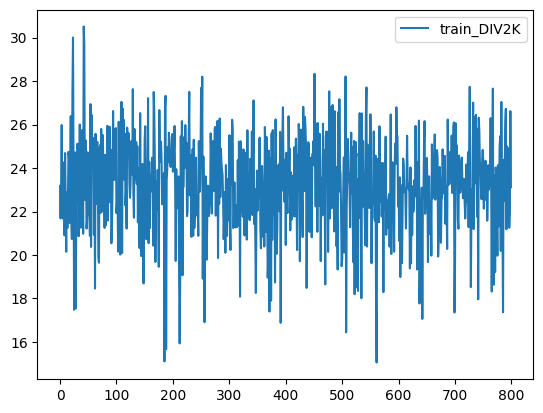

In [46]:
psnr_list = valid_train(model)
plt.plot(np.arange(len(psnr_list)), psnr_list, label='train_DIV2K')
plt.legend()
plt.plot()

In [47]:
np.mean(psnr_list)

23.18592396259308

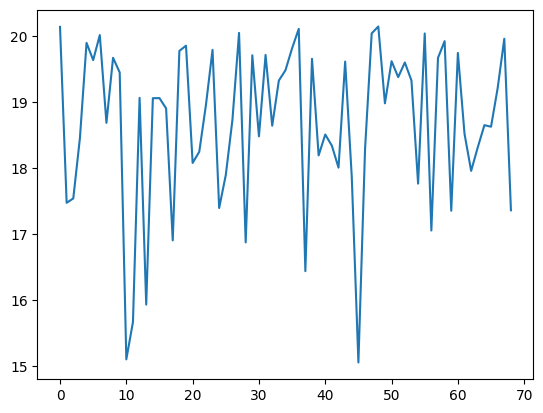

In [48]:
psnr_list = []
crop = torchvision.transforms.CenterCrop(480)
for idx in difficult_list:
    target = train_dataset_center[idx].unsqueeze(0)
    out = model(target)
    binary, rgb = rgb_binary_sim(out, 2e-3)
    crop_rgb = crop(rgb)
    crop_target = crop(target)
    psnr = tt.relativeLoss(crop_rgb, crop_target, tm.get_PSNR)
    psnr_list.append(psnr)
plt.plot(np.arange(len(psnr_list)), psnr_list)
plt.show()

In [49]:
np.mean(psnr_list)

18.682744233504586